<a href="https://colab.research.google.com/github/Eugeneantientropy/ML100Days/blob/main/HW_Day_99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果，作業請直接提交Day099_data_augmentation.ipynb

In [1]:
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)

            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


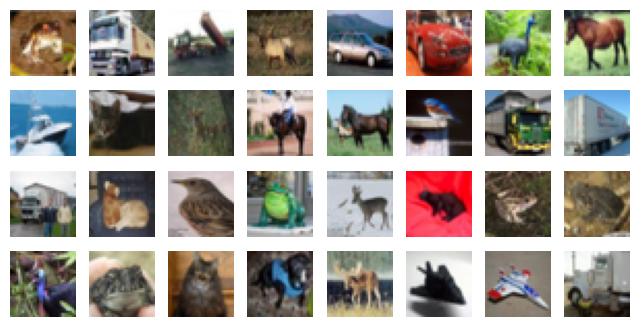

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

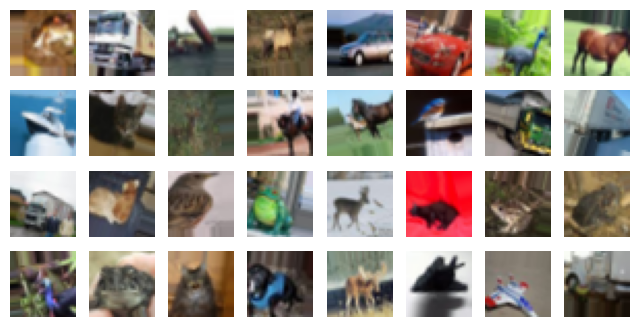

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True)
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

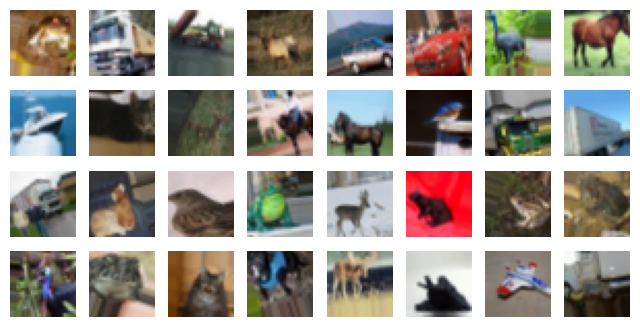

In [7]:

# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

In [8]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os
import warnings

In [9]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 讀取資料並檢視
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
# 將資料攤平成一維資料

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,250,858 (4.77 MB)

 Trainable params: 1,250,858 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
augment_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# Use model.fit instead of model.generator to train the model with a data generator
history = model.fit(augment_generator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


390/390 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - accuracy: 0.2425 - loss: 2.0591 - val_accuracy: 0.4759 - val_loss: 1.4300
Epoch 2/10
  1/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5234 - loss: 1.3886

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5234 - loss: 1.3886 - val_accuracy: 0.4663 - val_loss: 1.4582
Epoch 3/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.4382 - loss: 1.5568 - val_accuracy: 0.5354 - val_loss: 1.2743
Epoch 4/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4766 - loss: 1.4856 - val_accuracy: 0.5588 - val_loss: 1.2518
Epoch 5/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.5110 - loss: 1.3650 - val_accuracy: 0.5794 - val_loss: 1.1908
Epoch 6/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6016 - loss: 1.1079 - val_accuracy: 0.5813 - val_loss: 1.1720
Epoch 7/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.5580 - loss: 1.2448 - val_accuracy: 0.6568 - val_loss: 0.9657
Epoch 8/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5312 - loss: 1.1216 - val_accuracy: 0.6578 - val_loss: 0.9495
Epoch 9/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.5967 - loss: 1.1390 - val_accuracy: 0.657